In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from skimage import exposure

from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
# Define data paths
path = Path("../raw_data")
train_data = np.load(path/"Dataset5_raw_train.npz")
val_data = np.load(path/"Dataset5_raw_val.npz")
test_data = np.load(path/"Dataset5_raw_test.npz")

In [5]:
# Extract data from dictionaries
train_images = train_data["image"]
val_images = val_data["image"]
test_images = test_data["image"]
train_labels = train_data["image_label"].astype(int)
val_labels = val_data["image_label"].astype(int)
test_labels = test_data["image_label"].astype(int)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


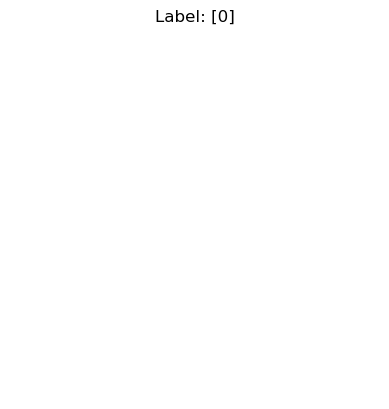

In [6]:
def display_random_image(images, labels):
    # Select a random index
    random_index = random.randint(0, len(images) - 1)
    
    # Select the corresponding image and label
    image = images[random_index]
    label = labels[random_index]

    # Display the image and label
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

# Call the function with the train_images and train_labels
display_random_image(train_images, train_labels)

In [7]:
def equalize_histogram_individual(images):
    for i in range(len(images)):
        images[i] = exposure.equalize_hist(images[i])

# Apply the function to the training images
equalize_histogram_individual(train_images)
# Apply the function to the validation images
equalize_histogram_individual(val_images)
# Apply the function to the testing images
equalize_histogram_individual(test_images) 

C:\Users\sem_w\anaconda3\Lib\site-packages\skimage\_shared\utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


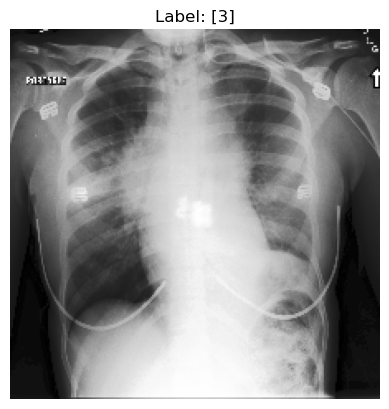

In [8]:
# display random contrasted training images with train_labels
display_random_image(train_images, train_labels)

In [9]:
train_labels.count

AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [8]:

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

def create_dataloader(images, labels, batch_size=64, shuffle=False):
    def collate_fn(batch):
        imgs, lbls = zip(*batch)
        imgs = torch.stack([torch.tensor(img).float().permute(2, 0, 1) / 255 for img in imgs])
        lbls = torch.tensor(lbls).long().squeeze()
        return imgs, lbls

    dataset = CustomDataset(images, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
    return dataloader

In [9]:
# Create DataLoaders
train_dl = create_dataloader(train_images, train_labels, batch_size=32, shuffle=True)
val_dl = create_dataloader(val_images, val_labels, batch_size=32)
test_dl = create_dataloader(test_images, test_labels, batch_size=32)

In [20]:
# Define the model (using EfficientNet-B0 here)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Modify the classifier
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.2),  # Adjust dropout rate as needed
    nn.Linear(num_ftrs, 5)  # Assuming 5 classes
)

In [21]:
# Move model to GPU if available
torch.cuda.empty_cache()
device = torch.device("cuda")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [22]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer with weight decay for L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [24]:
patience = 8  # How many epochs to wait after last improvement
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
# Set the accumulation steps
accumulation_steps = 2

# Training loop
for epoch in range(50):  
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(train_dl):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item()

    # Make sure to step the optimizer if the last batch was not a perfect multiple of accumulation steps
    if len(train_dl) % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

    # Check for improvement
    current_val_loss = running_val_loss / len(val_dl)
    print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_dl)}")
    print(f"Epoch {epoch+1}, Validation Loss: {current_val_loss}")

    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1

    # Early stopping check
    if epochs_no_improve == patience:
        print('Early stopping triggered')
        break

    # Step the scheduler
    scheduler.step(current_val_loss)

model.load_state_dict(best_model_state)

Epoch 1, Training Loss: 0.13433649895111097
Epoch 1, Validation Loss: 0.16921904291332948
Epoch 2, Training Loss: 0.11535491813718665
Epoch 2, Validation Loss: 0.11423972847178669
Epoch 3, Training Loss: 0.09712578224581872
Epoch 3, Validation Loss: 0.156523802539081
Epoch 4, Training Loss: 0.08268313666807144
Epoch 4, Validation Loss: 0.14120079958030568
Epoch 5, Training Loss: 0.07704598049376446
Epoch 5, Validation Loss: 0.13193579642176656
Epoch 6, Training Loss: 0.07018074187314134
Epoch 6, Validation Loss: 0.2053431074981146
Epoch 7, Training Loss: 0.06006721469712691
Epoch 7, Validation Loss: 0.1644046499480482
Epoch 8, Training Loss: 0.059095792317110436
Epoch 8, Validation Loss: 0.16363720717696506
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9, Training Loss: 0.023745114193506823
Epoch 9, Validation Loss: 0.11354587269168227
Epoch 10, Training Loss: 0.011938700652660401
Epoch 10, Validation Loss: 0.12286758571811267
Epoch 11, Training Loss: 0.0070192144

<All keys matched successfully>

In [25]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix 
# Move model to evaluation mode
model.eval()

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# No gradient needed
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the prediction (max probability)
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Use 'weighted' for imbalanced classes

print(f"Accuracy on Test Set: {accuracy}")
print(f"F1 Score on Test Set: {f1}")

Accuracy on Test Set: 0.9662079510703364
F1 Score on Test Set: 0.9661967682126393


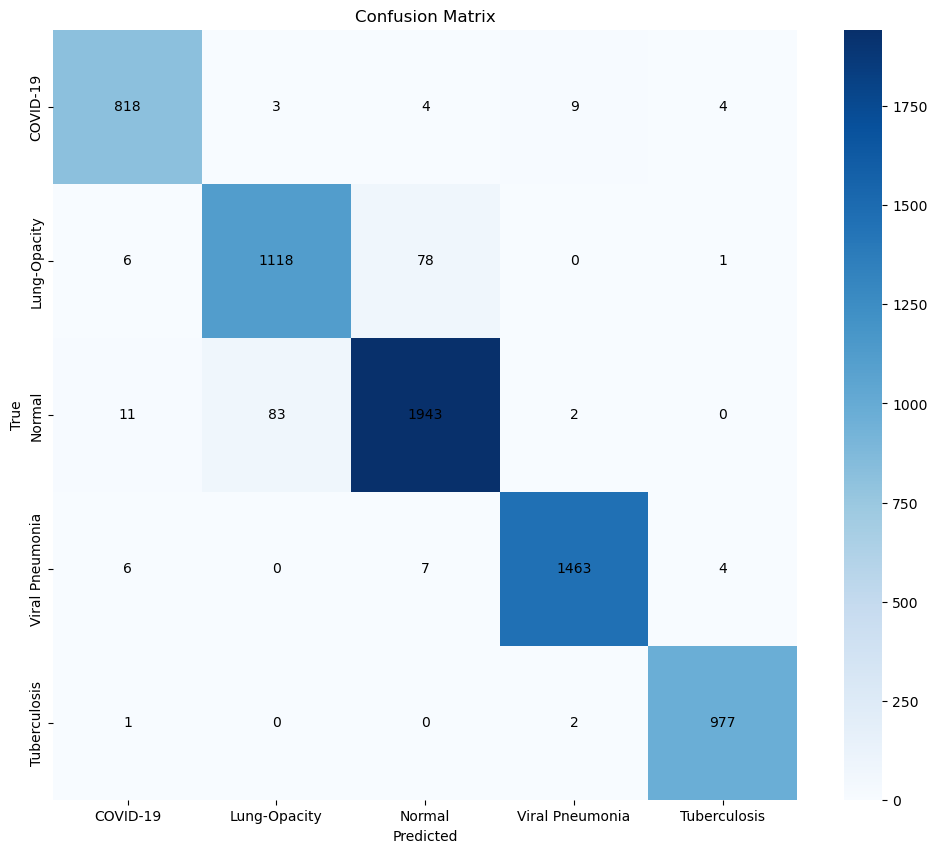

In [27]:
import seaborn as sns

# Define class labels
classes = ["COVID-19", "Lung-Opacity", "Normal", "Viral Pneumonia", "Tuberculosis"]
model.eval()

# Generate predictions
true_labels = []
predicted_labels = []
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting with explicit annotation loop
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', ax=ax, xticklabels=classes, yticklabels=classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j+0.5, i+0.5, cm[i, j], ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()